<a href="https://colab.research.google.com/github/coolmich0904/YouTube_Family_Plan_Policy_Chang_Impact_Analysis/blob/main/Youtube_Family_Plan_Policy_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Task: Install required libraries for data collection into the local directory
# Reference: Industry benchmark from Netflix (15-30% churn intent)
# Hypothesis: Youtube's integration with Youtube Music might lead to a 40% impact for non-complaint users

!pip install yfinance faker pandas numpy pytrends

import pandas as pd
import numpy as np
import yfinance as yf
import random
import seaborn as sns
import matplotlib.pyplot as plt
from faker import Faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.4 MB/s eta 0:00:00


In [5]:

faker= Faker()

# Generate raw data focusing on Family Plan issues
def generate_youtube_raw_data(n=1000):
    data=[]
    flag_date = pd.to_datetime('2025-09-01')

    for _ in range(n):
        # Assign Random Action Date within 2025
        action_date = faker.date_between(start_date='-1y', end_date='today')
        is_after_flag = pd.to_datetime(action_date) >= flag_date

        # Users after flag_date face 'Address Verification'
        if is_after_flag:
            # 40% churn hy[othesis based on the Netflix benchmark reference
            status = np.random.choice(['Cancelled', 'Active'], p=[0.4, 0.6])

            # If cancelled, dud they stay or leave??
            if status == 'Cancelled':
                outcome = np.random.choice(['Switch to Individual', 'Complete Exit'], p=[0.7, 0.3])
            else:
                outcome = 'N/A'

            data.append({
                'user_id': faker.uuid4(),
                'action_date': action_date,
                'is_after_flag': is_after_flag,
                'status': status,
                'final_outcome': outcome
            })
    return pd.DataFrame(data)

# Convert the date objects to strings to prevent JSON from turning them into numbers
youtube_df = generate_youtube_raw_data(1200)
youtube_df['action_date'] = youtube_df['action_date'].astype(str)

# Save to JSON
youtube_df.to_json('youtube_churn_analysis_raw.json', orient='records', indent=4)

print("Success: youtube_churn_analysis_raw.json generated with YouTube-only context.")


Success: youtube_churn_analysis_raw.json generated with YouTube-only context.


In [6]:
# Task: Clean Raw Youtube Churn Data

# Convert date string to datetime objects
# Map categorical data to numerical values for better analysis

# Load Generated JSON file
raw_data = pd.read_json('youtube_churn_analysis_raw.json')

# 1. Transform timestamp
raw_data['action_date'] = pd.to_datetime(raw_data['action_date'], errors='coerce')

# 2. Handle 'N/A' values in final_outcome
raw_data['final_outcome'] = raw_data['final_outcome'].replace('N/A', 'Stayed')

# 3. Numeric flag for churn (1 for cancelled, 0 for Active)
raw_data['is_churned'] = raw_data['status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

# Preview the cleaned Data
print(raw_data.info())
print(raw_data.head())

# Save the cleaned version
raw_data.to_csv('youtube_churn_cleaned_data.csv', index=False)
print("\nSaved Successfully")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        505 non-null    object        
 1   action_date    505 non-null    datetime64[ns]
 2   is_after_flag  505 non-null    bool          
 3   status         505 non-null    object        
 4   final_outcome  505 non-null    object        
 5   is_churned     505 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(1), object(3)
memory usage: 20.3+ KB
None
                                user_id action_date  is_after_flag     status  \
0  aac963e5-cc63-4c8f-97d7-e8cb633f48c0  2025-09-22           True  Cancelled   
1  4ec8ad92-9f02-4f65-87fc-2bae55968143  2025-10-05           True     Active   
2  698dc1ad-a81c-43b9-90bf-739f4dee4b13  2025-09-08           True     Active   
3  76a94a25-370c-4334-ac88-8eb9ac017613  2025-12-09           True  Cancelled   

In [7]:
# Now find the rate for is_churned == 1
churned_df = raw_data[raw_data['is_churned'] == 1]
churned_df.head()

,user_id,action_date,is_after_flag,status,final_outcome,is_churned
0,aac963e5-cc63-4c8f-97d7-e8cb633f48c0,2025-09-22,True,Cancelled,Switch to Individual,1
3,76a94a25-370c-4334-ac88-8eb9ac017613,2025-12-09,True,Cancelled,Switch to Individual,1
4,4878477e-7a47-4d89-a4c5-847a8ca8d3de,2026-02-05,True,Cancelled,Switch to Individual,1
5,7e4eb0f1-ea12-4843-8c4e-9b8eea227228,2025-12-18,True,Cancelled,Complete Exit,1
7,1a4b2906-980a-4f87-81c3-76bf1c38edc1,2025-10-16,True,Cancelled,Switch to Individual,1


In [8]:
# find the conversion rate for tranferring to the individual fare among the cancled people
conversion_rate = (len(churned_df[churned_df['final_outcome'] == 'Switch to Individual']) / len(churned_df)) * 100
print (f"Conversion Rate to Individual fare: {conversion_rate:.2f}%")

Conversion Rate to Individual fare: 72.31%


In [9]:
# Find complete exit rate
comp_churned = len(churned_df)
comp_exit_count = len(churned_df[churned_df['final_outcome'] == 'Complete Exit'])
exit_rate = (comp_exit_count / len(churned_df)) * 100

print(f"Total Churned: {len(churned_df)}")
print(f"Complete Exit Rate: {exit_rate: .2f}%")

Total Churned: 195
Complete Exit Rate:  27.69%


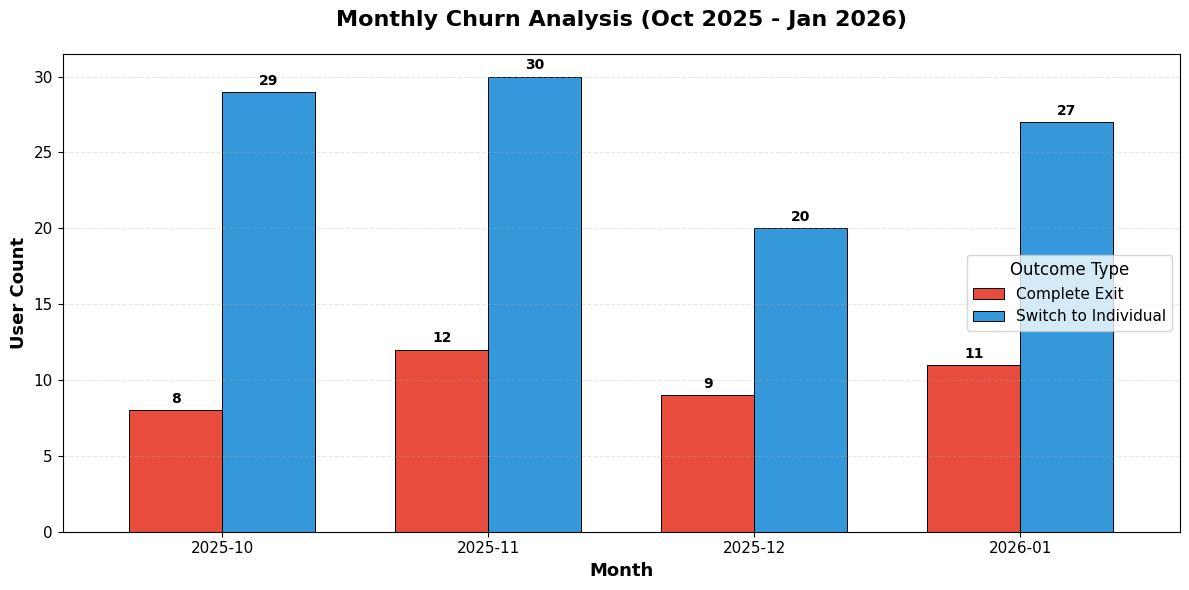


=== Monthly Churn Summary ===
final_outcome  Complete Exit  Switch to Individual
month                                             
2025-10                    8                    29
2025-11                   12                    30
2025-12                    9                    20
2026-01                   11                    27

Total churned users: 146


In [10]:
# Load data
df = pd.read_csv('youtube_churn_cleaned_data.csv')

# "YYYY-MM-DD"
df['action_date'] = pd.to_datetime(df['action_date'], errors='coerce')

# Filter for churned users only (is_churned = 1)
churned_df = df[df['is_churned'] == 1].copy()

# Create month column
churned_df['month'] = churned_df['action_date'].dt.strftime('%Y-%m')

# Filter for the period shown in your image (2025-10 to 2026-01)
churned_df = churned_df[
    (churned_df['action_date'] >= '2025-10-01') &
    (churned_df['action_date'] <= '2026-01-31')
]

# Group by month and final_outcome
plot_table = churned_df.groupby(['month', 'final_outcome']).size().unstack(fill_value=0)

# Reorder columns if needed for better visualization
if 'Complete Exit' in plot_table.columns and 'Switch to Individual' in plot_table.columns:
    plot_table = plot_table[['Complete Exit', 'Switch to Individual']]

# Create bar chart
ax = plot_table.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.7,
    color=['#E74C3C', '#3498DB'],
    edgecolor='black',
    linewidth=0.7
)

# Add data labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontweight='bold', fontsize=10)

# Formatting
plt.title('Monthly Churn Analysis (Oct 2025 - Jan 2026)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=13, fontweight='bold')
plt.ylabel('User Count', fontsize=13, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Outcome Type', fontsize=11, title_fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Save and show
plt.savefig('monthly_churn_outcome.png', dpi=300)
plt.show()

print("\n=== Monthly Churn Summary ===")
print(plot_table)
print(f"\nTotal churned users: {len(churned_df)}")

In [11]:
# Task: Clean Raw Youtube Churn Data

# Convert date string to datetime objects
# Map categorical data to numerical values for better analysis

# Load Generated JSON file
raw_data = pd.read_json('youtube_churn_analysis_raw.json')

# Handle 'N/A' values in final_outcome
raw_data['final_outcome'] = raw_data['final_outcome'].replace('N/A', 'Stayed')

#  Numeric flag for churn (1 for cancelled, 0 for Active)
raw_data['is_churned'] = raw_data['status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

# Preview the cleaned Data
print(raw_data.head())

# Save the cleaned version
raw_data.to_csv('youtube_churn_cleaned_data.csv', index=False)
print("\nSaved Successfully")


                                user_id action_date  is_after_flag     status  \
0  aac963e5-cc63-4c8f-97d7-e8cb633f48c0  2025-09-22           True  Cancelled   
1  4ec8ad92-9f02-4f65-87fc-2bae55968143  2025-10-05           True     Active   
2  698dc1ad-a81c-43b9-90bf-739f4dee4b13  2025-09-08           True     Active   
3  76a94a25-370c-4334-ac88-8eb9ac017613  2025-12-09           True  Cancelled   
4  4878477e-7a47-4d89-a4c5-847a8ca8d3de  2026-02-05           True  Cancelled   

          final_outcome  is_churned  
0  Switch to Individual           1  
1                Stayed           0  
2                Stayed           0  
3  Switch to Individual           1  
4  Switch to Individual           1  

Saved Successfully


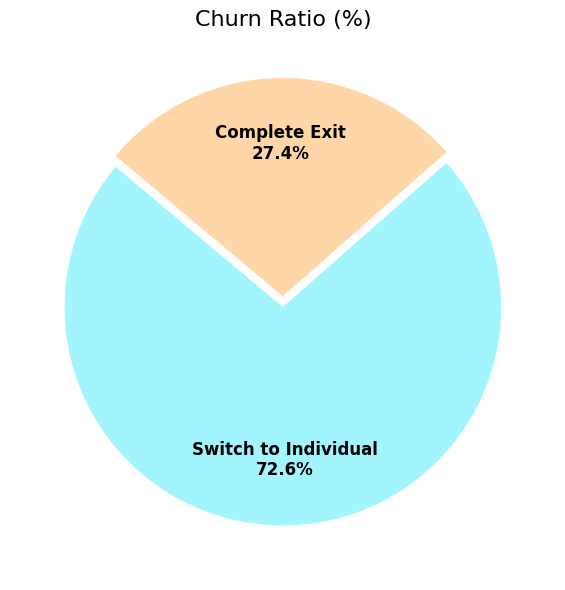

In [12]:
from IPython.core.magics import auto
# Pie Chart : Churn Ratio
outcome_counts = churned_df['final_outcome'].value_counts()
labels=outcome_counts.index
values=outcome_counts.values

# Create a pie chart

plt.figure(figsize=(6, 6))

wedges, texts, autotexts = plt.pie(
        values,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette(['#A2F4FD', '#FFD6A7']),
        explode=[0.05 if i == 'Complete Exit' else 0 for i in labels],
        pctdistance=0.7, # Adjusted to place percentage & Category name inside
        labeldistance=1.1,
        textprops={'fontsize':12, 'fontweight':'bold'})

# Label position
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
  # combine label of outside and value of inside
  combined_text = f"{labels[i]}\n{autotext.get_text()}"

  autotext.set_text(combined_text)
  autotext.set_fontsize(12)


  # remove the label outside of pie
  text.set_text("")                                  #


plt.title('Churn Ratio (%)', fontsize=16)
plt.tight_layout()
plt.savefig('churn_ratio.png', dpi=300)
plt.show()

In [ ]:
# ---  Final Data Export for Power BI & GitHub ---

import pandas as pd
from google.colab import files

# 1. Format date as a fixed string to prevent numeric conversion errors
# Use 'raw_data' or 'cleaned_data' based on your final variable name
df_final = raw_data.copy()

# Ensure the date column is formatted as YYYY-MM-DD
df_final['action_date'] = pd.to_datetime(df_final['action_date']).dt.strftime('%Y-%m-%d')

# 2. Define the output filename
export_filename = 'youtube_churn_final_report.csv'

# 3. Save to the Colab server environment
df_final.to_csv(export_filename, index=False)

# 4. Trigger the local browser download
print(f"Exporting {export_filename} to local storage...")
files.download(export_filename)

# 5. Quick validation check
print("Export Successful. Date Format Preview:")
print(df_final['action_date'].head())

Exporting youtube_churn_final_report.csv to local storage...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export Successful. Date Format Preview:
0    2025-11-19
1    2025-11-29
2    2025-11-03
3    2025-12-16
4    2025-09-28
Name: action_date, dtype: object
